In [1]:
from torchvision.models import resnet50, ResNet50_Weights, vit_b_16, ViT_B_16_Weights
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torchvision import datasets
from torchvision.transforms.v2 import ToImage, Resize, CenterCrop, Compose
from transformers import CLIPProcessor, CLIPModel, CLIPVisionModel
import torch
from torch import nn
import pandas as pd
from PIL import Image
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from semantic_selective_classification import semantic_binning
from utils import ECE_calc

path_huggingface = os.path.expandvars('$DSDIR/HuggingFace_Models/') 
PUG_ANIMAL_PATH = os.path.expandvars('$SCRATCH/PUG_Animal/')
path_results = '../results/PUG/Animal/'


class UnrealDatasetCustom(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = pd.read_csv(csv_path)
        self.df.astype(str)
        self.images_folder = images_folder
        self.transform = transform
        self.dict_label_to_idx = {l: i for i, l in enumerate(sorted(self.df['character_name'].unique()))}
        self.dict_idx_to_label = {i: l for i, l in enumerate(sorted(self.df['character_name'].unique()))}

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = self.df['filename'][index]
        label = self.df['character_name'][index]
        image = Image.open(os.path.join(self.images_folder, label, filename))
        if self.transform is not None:
            image = self.transform(image)
        return image, label, self.df['world_name'][index], self.df['character_scale'][index], self.df['character_texture'][index], self.df['camera_yaw'][index]
    
    def labels_to_idx(self, labels):
        return [self.dict_label_to_idx[l] for l in labels]
    
    def idx_to_labels(self, idx):
        return [self.dict_idx_to_label[i] for i in idx]

attributes_names = ['character_name', 'world_name', 'character_scale', 'character_texture', 'camera_yaw']

model_name = 'ViT-B16'
models_and_weights_imagenet = {
    'ResNet-50': (resnet50, ResNet50_Weights.DEFAULT),
    'ViT-B16': (vit_b_16, ViT_B_16_Weights.DEFAULT), 
}


# Show data

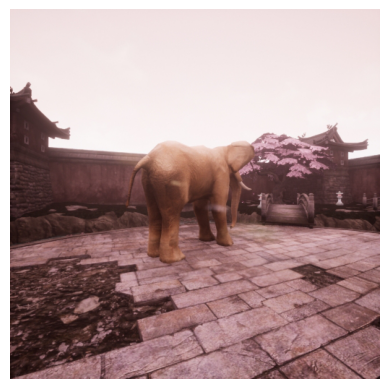

In [66]:
dataset = UnrealDatasetCustom(csv_path=PUG_ANIMAL_PATH+"labels_pug_animal.csv", images_folder=PUG_ANIMAL_PATH, transform=None)

i = 198356
plt.figure()
plt.imshow(dataset[i][0])
plt.axis('off')
plt.savefig(path_results+'_'.join([str(x) for x in dataset[i][1:6]])+'.png')

# For classifier pre-trained on ImageNet

keep 30 animals


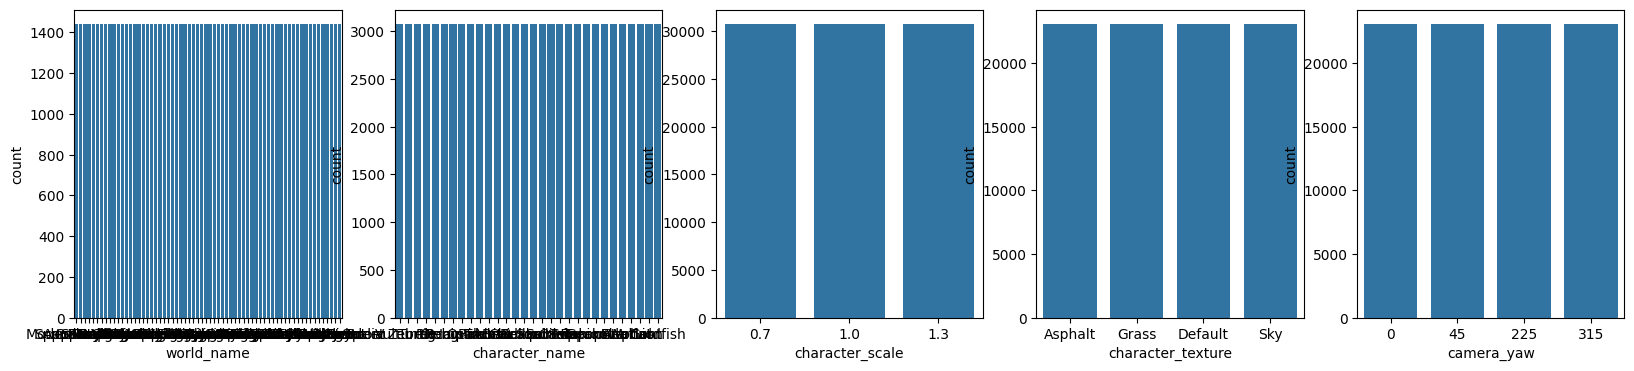

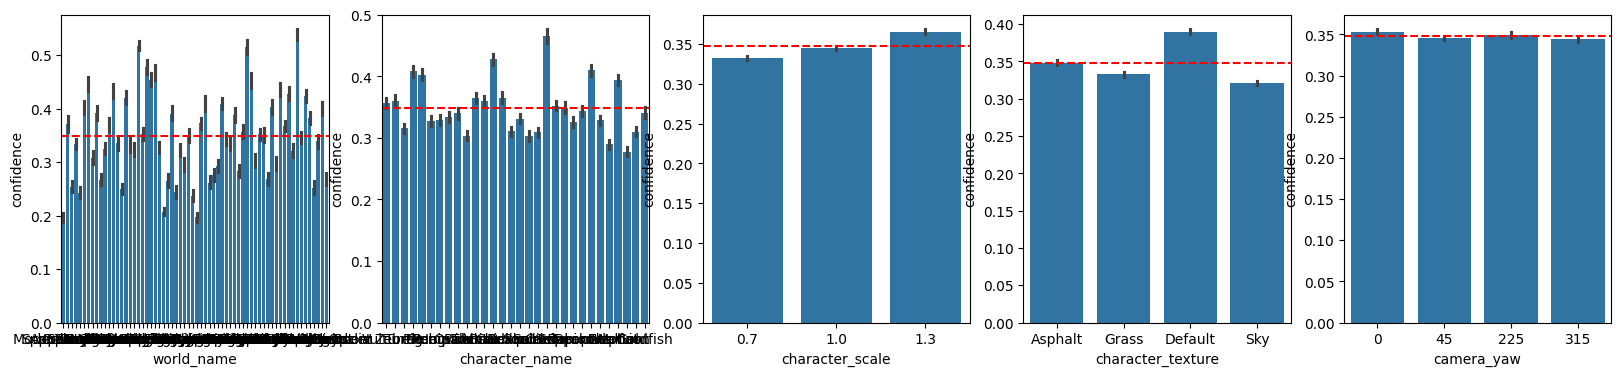

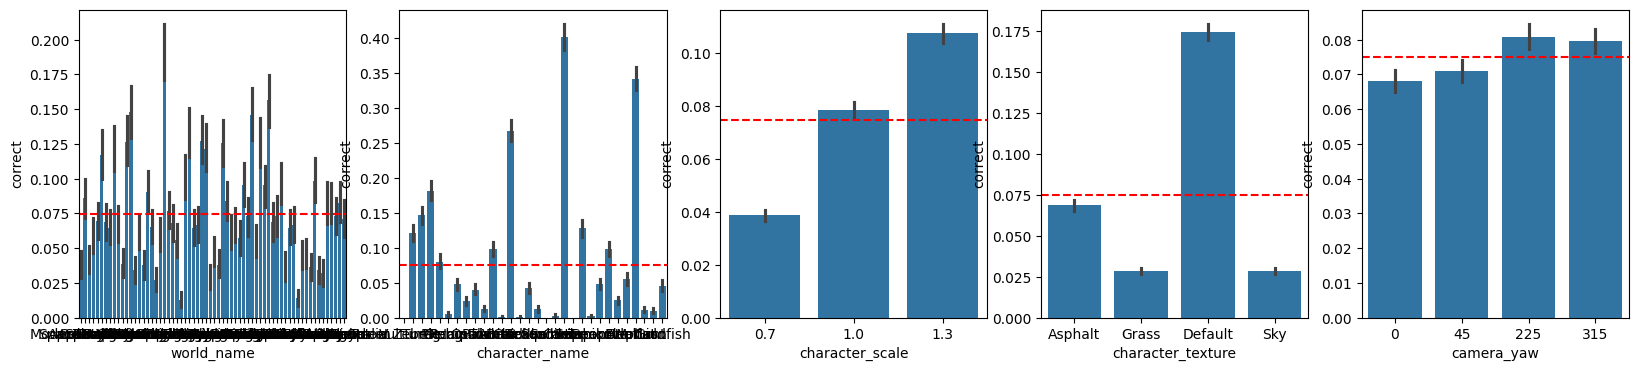

In [2]:
# build model and data
architecture, weights = models_and_weights_imagenet[model_name]
classifier = architecture(weights=weights).eval().cuda()
transforms = weights.transforms()
dataset = UnrealDatasetCustom(csv_path=PUG_ANIMAL_PATH+"labels_pug_animal.csv", images_folder=PUG_ANIMAL_PATH, transform=transforms)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)


# only keep animals that are in ImageNet
imagenetIdx_to_charName = {
    1: 'Goldfish',
    385: 'Elephant',
    386: 'Elephant',
    354: 'Camel',
    145: 'Penguin',
    340: 'Zebra',
    33: 'Turtle',
    34: 'Turtle',
    35: 'Turtle',
    36: 'Turtle',
    37: 'Turtle',
    387: 'Bear',
    388: 'Bear',
    337: 'Beaver',
    49: 'Crocodile',
    50: 'Crocodile',
    363: 'Armadillo',
    281: 'Cat',
    282: 'Cat',
    283: 'Cat',
    284: 'Cat',
    285: 'Cat',
    286: 'Cat',
    287: 'Cat',
    288: 'Cat',
    289: 'Cat',
    290: 'Cat',
    291: 'Cat',
    292: 'Cat',
    293: 'Cat',
    38: 'Gecko',
    344: 'Hippopotamus',
    352: 'Impala',
    291: 'Lion',
    148: 'Orca',
    341: 'Pig',
    330: 'Rabbit',
    331: 'Rabbit',
    332: 'Rabbit',
    335: 'Squirrel',
    269: 'Wolf',
    270: 'Wolf',
    271: 'Wolf',
    272: 'Wolf',
    83: 'Chicken',
    9: 'Ostrich',
    15: 'Robin',
    100: 'Swan',
    96: 'Toucan',
    23: 'Vulture',
    310: 'Ant',
    71: 'Scorpion',
    76: 'Tarantula',
    391: 'Salmon',
}
print(f'keep {len(set(imagenetIdx_to_charName.values()))} animals')
dataset.df = dataset.df[dataset.df['character_name'].isin(set(imagenetIdx_to_charName.values()))].reset_index(drop=True)


# compute classifier predictions and correctness
path_res_file = path_results+f'res_{model_name}_pretrained.csv'
if os.path.exists(path_res_file):
    df_res = pd.read_csv(path_res_file)
else:
    list_res = []
    for data in dataloader:
        images = data[0].cuda()
        labels = data[1]
        with torch.no_grad():
            logits = classifier(images)
            probas = torch.softmax(logits, axis=1)
        confidences, pred = probas.max(dim=1)
        for i in range(pred.shape[0]):
            pred_names = [imagenetIdx_to_charName[p.item()] if p.item() in imagenetIdx_to_charName.keys() else 'Other' for p in pred]
        correct = np.array(pred_names) == np.array(labels)
        list_res.append(pd.DataFrame({'confidence': confidences.cpu(), 'prediction': pred_names, 'correct': correct, 
            'character_name': labels, 'world_name': data[2], 'character_scale': data[3], 'character_texture': data[4], 'camera_yaw': data[5]}))
    df_res = pd.concat(list_res)
    df_res = df_res.reset_index(drop=True)
    df_res.to_csv(path_res_file)

avg_confid = df_res['confidence'].mean()
global_acc = df_res['correct'].mean()


# plot some stats
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, attribute in enumerate(attributes_names):
    sns.countplot(df_res, x=attribute, ax=axs.flatten()[i])

fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, attribute in enumerate(attributes_names):
    sns.barplot(df_res, x=attribute, y='confidence', ax=axs.flatten()[i])
    axs.flatten()[i].axhline(y=avg_confid, color='r', linestyle='--', label='Average Confidence')

fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, attribute in enumerate(attributes_names):
    sns.barplot(df_res, x=attribute, y='correct', ax=axs.flatten()[i])
    axs.flatten()[i].axhline(y=global_acc, color='r', linestyle='--', label='Global Accuracy')

In [3]:
df_calib, df_test = train_test_split(df_res, test_size=0.5, random_state=0, shuffle=True, stratify=df_res['character_name'])

auroc_subdomain = {}
for subdomain_attribute in ['world_name', 'character_scale', 'character_texture', 'camera_yaw', 'prediction']:
    df_test = semantic_binning(df_calib, df_test, [subdomain_attribute], df_res['character_name'].unique())
    auroc_subdomain[subdomain_attribute] = roc_auc_score(df_test['correct'], df_test['subdomain_score'])
sorted_attributes = sorted(auroc_subdomain, key=auroc_subdomain.get, reverse=True)

['world_name']
64 subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.770 AUROC subdomains: 0.636


/gpfsdswork/projects/rech/dcf/ulb98yg/semantics/code/semantic_selective_classification.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test.loc[idx_na, 'subdomain_score'] = df_test['prediction'].replace(accuracy_for_prediction)


ECE baseline: 0.272 ECE: 0.003

['character_scale']
3 subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.770 AUROC subdomains: 0.612
ECE baseline: 0.272 ECE: 0.002

['character_texture']
4 subdomains


/gpfsdswork/projects/rech/dcf/ulb98yg/semantics/code/semantic_selective_classification.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test.loc[idx_na, 'subdomain_score'] = df_test['prediction'].replace(accuracy_for_prediction)


0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.770 AUROC subdomains: 0.718
ECE baseline: 0.272 ECE: 0.003

['camera_yaw']
4 subdomains


/gpfsdswork/projects/rech/dcf/ulb98yg/semantics/code/semantic_selective_classification.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test.loc[idx_na, 'subdomain_score'] = df_test['prediction'].replace(accuracy_for_prediction)


0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.770 AUROC subdomains: 0.518


/gpfsdswork/projects/rech/dcf/ulb98yg/semantics/code/semantic_selective_classification.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test.loc[idx_na, 'subdomain_score'] = df_test['prediction'].replace(accuracy_for_prediction)


ECE baseline: 0.272 ECE: 0.002

['prediction']
31 subdomains
10 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.770 AUROC subdomains: 0.991
ECE baseline: 0.272 ECE: 0.002



/gpfsdswork/projects/rech/dcf/ulb98yg/semantics/code/semantic_selective_classification.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test.loc[idx_na, 'subdomain_score'] = df_test['prediction'].replace(accuracy_for_prediction)


['prediction']
31 subdomains
10 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.770 AUROC subdomains: 0.991
ECE baseline: 0.272 ECE: 0.002

['prediction', 'character_texture']


/gpfsdswork/projects/rech/dcf/ulb98yg/semantics/code/semantic_selective_classification.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test.loc[idx_na, 'subdomain_score'] = df_test['prediction'].replace(accuracy_for_prediction)


101 subdomains
70 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.770 AUROC subdomains: 0.993
ECE baseline: 0.272 ECE: 0.003



/gpfsdswork/projects/rech/dcf/ulb98yg/semantics/code/semantic_selective_classification.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test.loc[idx_na, 'subdomain_score'] = df_test['prediction'].replace(accuracy_for_prediction)


['prediction', 'character_texture', 'world_name']
1841 subdomains
2013 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.770 AUROC subdomains: 0.992
ECE baseline: 0.272 ECE: 0.007



/gpfsdswork/projects/rech/dcf/ulb98yg/semantics/code/semantic_selective_classification.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test.loc[idx_na, 'subdomain_score'] = df_test['prediction'].replace(accuracy_for_prediction)


['prediction', 'character_texture', 'world_name', 'character_scale']
3490 subdomains
3890 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.770 AUROC subdomains: 0.987
ECE baseline: 0.272 ECE: 0.008



/gpfsdswork/projects/rech/dcf/ulb98yg/semantics/code/semantic_selective_classification.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test.loc[idx_na, 'subdomain_score'] = df_test['prediction'].replace(accuracy_for_prediction)


['prediction', 'character_texture', 'world_name', 'character_scale', 'camera_yaw']
7332 subdomains
4835 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.770 AUROC subdomains: 0.989
ECE baseline: 0.272 ECE: 0.004



/gpfsdswork/projects/rech/dcf/ulb98yg/semantics/code/semantic_selective_classification.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test.loc[idx_na, 'subdomain_score'] = df_test['prediction'].replace(accuracy_for_prediction)


(0.0001, 1.0)

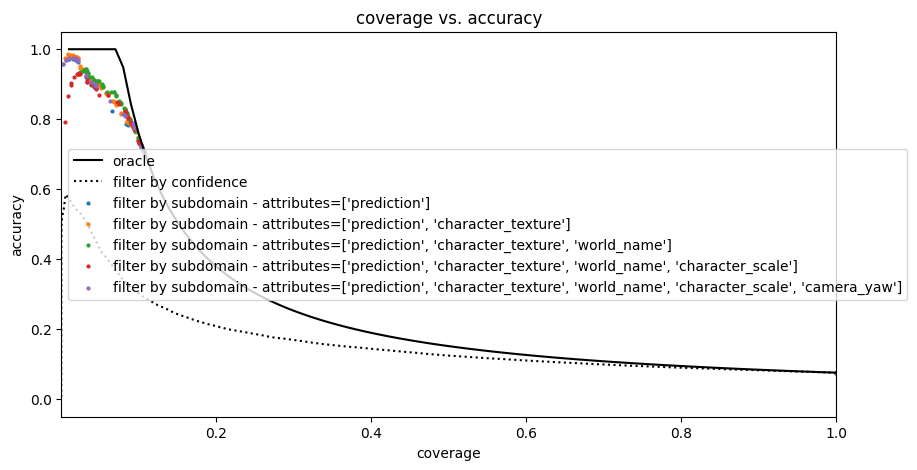

In [4]:
domain_cutoff_baseline = np.linspace(0.01, 1, 100)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = df_test['confidence'] > cut
    coverage_baseline[i] = idx_domain.mean()
    acc_baseline[i] = df_test[idx_domain]['correct'].mean()

domain_cutoff_oracle = np.linspace(0.01, 1, 100)
coverage_oracle = np.zeros_like(domain_cutoff_oracle)
acc_oracle = np.zeros_like(domain_cutoff_oracle)
for i, cut in enumerate(domain_cutoff_oracle):
    idx_domain = df_test.sort_values(by='correct', ascending=False).index[:int(cut*len(df_test))]
    coverage_oracle[i] = cut
    acc_oracle[i] = df_test.loc[idx_domain]['correct'].mean()
    
# plot base
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax1.set_title(f'coverage vs. accuracy')
ax1.set_xlabel('coverage')
ax1.set_ylabel('accuracy')
ax1.plot(coverage_oracle, acc_oracle, c='k', label='oracle')
ax1.plot(coverage_baseline, acc_baseline, c='k', ls=':', label='filter by confidence')

for k in range(len(sorted_attributes)):
    attributes = sorted_attributes[:k+1]
    df_test = semantic_binning(df_calib, df_test, attributes, df_res['character_name'].unique())

    coverage = np.zeros(len(df_test['subdomain_score'].unique()))
    accuracy = np.zeros(len(df_test['subdomain_score'].unique()))
    for i, cut in enumerate(sorted(df_test['subdomain_score'].unique(), reverse=True)):
        idx_domain = df_test['subdomain_score'] >= cut
        coverage[i] = idx_domain.mean()
        accuracy[i] = df_test[idx_domain]['correct'].mean()
    ax1.scatter(coverage, accuracy, s=4, label=f'filter by subdomain - attributes={attributes}')

plt.legend()
ax1.set_xlim(0.0001, 1)

In [5]:
print('NOTE: adding attributes from their individual AUROC rankings is not necessarily the best way as the multiplication of domains negatively impacts the perfo. For instance world_name adds many subdomains and it is better to first add character_scale.')

NOTE: adding attributes from their individual AUROC rankings is not necessarily the best way as the multiplication of domains negatively impacts the perfo. For instance world_name adds many subdomains and it is better to first add character_scale.


['prediction', 'character_texture', 'character_scale']
256 subdomains
31 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.768 AUROC subdomains: 0.993
ECE baseline: 0.273 ECE: 0.003



/gpfsdswork/projects/rech/dcf/ulb98yg/semantics/code/semantic_selective_classification.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test.loc[idx_na, 'subdomain_score'] = df_test['prediction'].replace(accuracy_for_prediction)


['prediction', 'character_texture', 'character_scale']
250 subdomains
81 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.769 AUROC subdomains: 0.992
ECE baseline: 0.273 ECE: 0.003



/gpfsdswork/projects/rech/dcf/ulb98yg/semantics/code/semantic_selective_classification.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test.loc[idx_na, 'subdomain_score'] = df_test['prediction'].replace(accuracy_for_prediction)


['prediction', 'character_texture', 'character_scale']
231 subdomains
210 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.769 AUROC subdomains: 0.991
ECE baseline: 0.272 ECE: 0.004



/gpfsdswork/projects/rech/dcf/ulb98yg/semantics/code/semantic_selective_classification.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test.loc[idx_na, 'subdomain_score'] = df_test['prediction'].replace(accuracy_for_prediction)


['prediction', 'character_texture', 'character_scale']
207 subdomains
395 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.768 AUROC subdomains: 0.988
ECE baseline: 0.273 ECE: 0.003



/gpfsdswork/projects/rech/dcf/ulb98yg/semantics/code/semantic_selective_classification.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test.loc[idx_na, 'subdomain_score'] = df_test['prediction'].replace(accuracy_for_prediction)


(0.0001, 1.0)

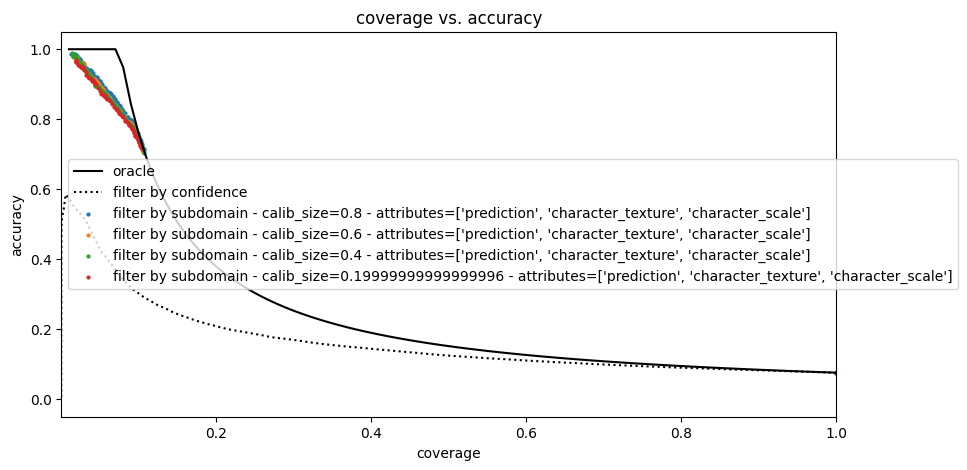

In [6]:
domain_cutoff_baseline = np.linspace(0.01, 1, 100)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = df_test['confidence'] > cut
    coverage_baseline[i] = idx_domain.mean()
    acc_baseline[i] = df_test[idx_domain]['correct'].mean()

domain_cutoff_oracle = np.linspace(0.01, 1, 100)
coverage_oracle = np.zeros_like(domain_cutoff_oracle)
acc_oracle = np.zeros_like(domain_cutoff_oracle)
for i, cut in enumerate(domain_cutoff_oracle):
    idx_domain = df_test.sort_values(by='correct', ascending=False).index[:int(cut*len(df_test))]
    coverage_oracle[i] = cut
    acc_oracle[i] = df_test.loc[idx_domain]['correct'].mean()
    
# plot base
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax1.set_title(f'coverage vs. accuracy')
ax1.set_xlabel('coverage')
ax1.set_ylabel('accuracy')
ax1.plot(coverage_oracle, acc_oracle, c='k', label='oracle')
ax1.plot(coverage_baseline, acc_baseline, c='k', ls=':', label='filter by confidence')


attributes = ['prediction', 'character_texture', 'character_scale']
for test_size in [0.2, 0.4, 0.6, 0.8]:
    df_calib, df_test = train_test_split(df_res, test_size=test_size, random_state=0, shuffle=True, stratify=df_res['character_name'])
    df_test = semantic_binning(df_calib, df_test, attributes, df_res['character_name'].unique())

    coverage = np.zeros(len(df_test['subdomain_score'].unique()))
    accuracy = np.zeros(len(df_test['subdomain_score'].unique()))
    for i, cut in enumerate(sorted(df_test['subdomain_score'].unique(), reverse=True)):
        idx_domain = df_test['subdomain_score'] >= cut
        coverage[i] = idx_domain.mean()
        accuracy[i] = df_test[idx_domain]['correct'].mean()
    ax1.scatter(coverage, accuracy, s=4, label=f'filter by subdomain - calib_size={1-test_size} - attributes={attributes}')

plt.legend()
ax1.set_xlim(0.0001, 1)

# Fine-tuned classifier

In [ ]:
# Build model 
architecture, weights = models_and_weights_imagenet[model_name]
classifier = architecture(weights=weights).eval().cuda()
transforms = weights.transforms()
dataset = UnrealDatasetCustom(csv_path=PUG_ANIMAL_PATH+"labels_pug_animal.csv", images_folder=PUG_ANIMAL_PATH, transform=transforms)

path_model = path_results + f'{model_name}_finetuned_weights.pth'
if model_name == 'ViT-B16':
    classifier.heads.head = torch.nn.Linear(classifier.heads.head.in_features, dataset.df['character_name'].nunique()).cuda()
classifier.load_state_dict(torch.load(path_model))
for param in classifier.parameters():
    param.requires_grad = False
classifier.eval()

# Build balanced datasets: train, calib, test of size [0.5, 0.25, 0.25]
train_idx, valid_idx = train_test_split(np.arange(len(dataset)), train_size=0.5, random_state=0, shuffle=True, stratify=dataset.df['character_name'])
train_dataset = Subset(dataset, train_idx)
valid_dataset = Subset(dataset, valid_idx)
# split validation into calib and test
calib_idx, test_idx = train_test_split(np.arange(len(valid_dataset)), test_size=0.5, random_state=0, shuffle=True, stratify=dataset.df.iloc[valid_idx]['character_name'])
calib_dataset = Subset(valid_dataset, calib_idx)
test_dataset = Subset(valid_dataset, test_idx)

# Build dataloaders
train_loader = DataLoader(train_dataset, batch_size=512, num_workers=4, shuffle=True)
calib_loader = DataLoader(calib_dataset, batch_size=512, num_workers=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, num_workers=4, shuffle=False)

In [ ]:
# compute classifier predictions and correctness
for calib_test, dataloader in zip(['calib', 'test'], [calib_loader, test_loader]):

    path_res_file = path_results+f'res_{model_name}_finetuned_{calib_test}.csv'
    if os.path.exists(path_res_file):
        df_res = pd.read_csv(path_res_file)
    else:
        list_res = []
        for data in dataloader:
            images = data[0].cuda()
            labels = dataset.labels_to_idx(data[1])
            labels = torch.tensor(labels).cuda()
            with torch.no_grad():
                logits = classifier(images)
                probas = torch.softmax(logits, axis=1)
            confidences, pred = probas.max(dim=1)
            correct = (pred == labels)
            list_res.append(pd.DataFrame({'confidence': confidences.cpu(), 'prediction': pred.cpu().numpy(), 'correct': correct.cpu().numpy(), 
                'character_name': labels.cpu().numpy(), 'world_name': data[2], 'character_scale': data[3], 'character_texture': data[4], 'camera_yaw': data[5]}))
        df_res = pd.concat(list_res)
        df_res = df_res.reset_index(drop=True)
        df_res.to_csv(path_res_file)
    if calib_test == 'calib':
        df_calib = df_res
    elif calib_test == 'test':
        df_test = df_res

['world_name']
64 subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.986 AUROC subdomains: 0.735
ECE baseline: 0.002 ECE: 0.000

['prediction']
70 subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.986 AUROC subdomains: 0.747
ECE baseline: 0.002 ECE: 0.000

['character_scale']
3 subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.986 AUROC subdomains: 0.640
ECE baseline: 0.002 ECE: 0.000

['character_texture']
4 subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.986 AUROC subdomains: 0.597
ECE baseline: 0.002 ECE: 0.000

['camera_yaw']
4 subdomains
0 nan values (they appear beca

(0.0001, 1.0)

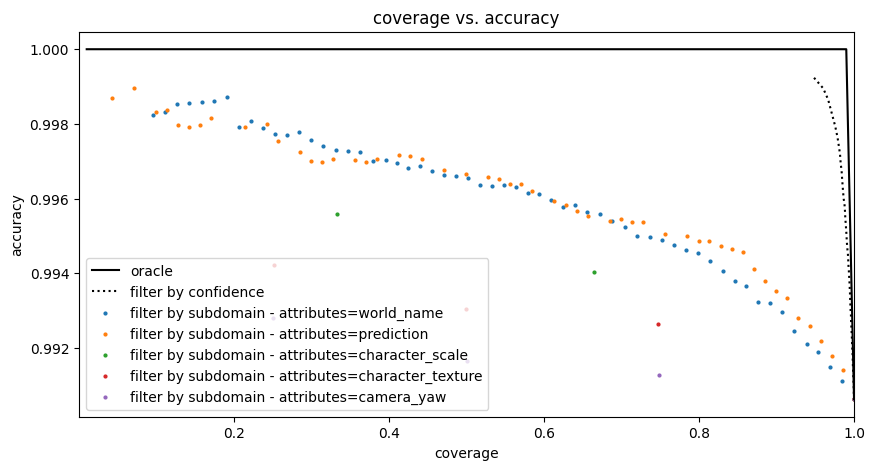

In [9]:
domain_cutoff_baseline = np.linspace(0.01, 1, 100)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = df_test['confidence'] > cut
    coverage_baseline[i] = idx_domain.mean()
    acc_baseline[i] = df_test[idx_domain]['correct'].mean()

domain_cutoff_oracle = np.linspace(0.01, 1, 100)
coverage_oracle = np.zeros_like(domain_cutoff_oracle)
acc_oracle = np.zeros_like(domain_cutoff_oracle)
for i, cut in enumerate(domain_cutoff_oracle):
    idx_domain = df_test.sort_values(by='correct', ascending=False).index[:int(cut*len(df_test))]
    coverage_oracle[i] = cut
    acc_oracle[i] = df_test.loc[idx_domain]['correct'].mean()
    
# plot base
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax1.set_title(f'coverage vs. accuracy')
ax1.set_xlabel('coverage')
ax1.set_ylabel('accuracy')
ax1.plot(coverage_oracle, acc_oracle, c='k', label='oracle')
ax1.plot(coverage_baseline, acc_baseline, c='k', ls=':', label='filter by confidence')

for attributes in ['world_name', 'prediction', 'character_scale', 'character_texture', 'camera_yaw']:
    df_test = semantic_binning(df_calib, df_test, [attributes], df_res['character_name'].unique())

    coverage = np.zeros(len(df_test['subdomain_score'].unique()))
    accuracy = np.zeros(len(df_test['subdomain_score'].unique()))
    for i, cut in enumerate(sorted(df_test['subdomain_score'].unique(), reverse=True)):
        idx_domain = df_test['subdomain_score'] >= cut
        coverage[i] = idx_domain.mean()
        accuracy[i] = df_test[idx_domain]['correct'].mean()
    ax1.scatter(coverage, accuracy, s=4, label=f'filter by subdomain - attributes={attributes}')

plt.legend()
ax1.set_xlim(0.0001, 1)

In [ ]:
domain_cutoff_baseline = np.linspace(0.01, 1, 100)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = df_test['confidence'] > cut
    coverage_baseline[i] = idx_domain.mean()
    acc_baseline[i] = df_test[idx_domain]['correct'].mean()

domain_cutoff_oracle = np.linspace(0.01, 1, 100)
coverage_oracle = np.zeros_like(domain_cutoff_oracle)
acc_oracle = np.zeros_like(domain_cutoff_oracle)
for i, cut in enumerate(domain_cutoff_oracle):
    idx_domain = df_test.sort_values(by='correct', ascending=False).index[:int(cut*len(df_test))]
    coverage_oracle[i] = cut
    acc_oracle[i] = df_test.loc[idx_domain]['correct'].mean()
    
# plot base
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax1.set_title(f'coverage vs. accuracy')
ax1.set_xlabel('coverage')
ax1.set_ylabel('accuracy')
ax1.plot(coverage_oracle, acc_oracle, c='k', label='oracle')
ax1.plot(coverage_baseline, acc_baseline, c='k', ls=':', label='filter by confidence')

attributes = ['world_name', 'prediction']
df_test = semantic_binning(df_calib, df_test, attributes, df_res['character_name'].unique())

coverage = np.zeros(len(df_test['subdomain_score'].unique()))
accuracy = np.zeros(len(df_test['subdomain_score'].unique()))
for i, cut in enumerate(sorted(df_test['subdomain_score'].unique(), reverse=True)):
    idx_domain = df_test['subdomain_score'] >= cut
    coverage[i] = idx_domain.mean()
    accuracy[i] = df_test[idx_domain]['correct'].mean()
ax1.scatter(coverage, accuracy, s=4, label=f'filter by subdomain - attributes={attributes}')

plt.legend()
ax1.set_xlim(0.0001, 1)

['world_name', 'prediction']
4480 subdomains


# Fine tuned classifier (last layer only)

In [2]:
# Build model 
architecture, weights = models_and_weights_imagenet[model_name]
classifier = architecture(weights=weights).eval().cuda()
transforms = weights.transforms()
dataset = UnrealDatasetCustom(csv_path=PUG_ANIMAL_PATH+"labels_pug_animal.csv", images_folder=PUG_ANIMAL_PATH, transform=transforms)

path_model = path_results + f'{model_name}_finetuned_lastlayer_weights.pth'
if model_name == 'ViT-B16':
    classifier.heads.head = torch.nn.Linear(classifier.heads.head.in_features, dataset.df['character_name'].nunique()).cuda()
classifier.load_state_dict(torch.load(path_model))
for param in classifier.parameters():
    param.requires_grad = False
classifier.eval()

# Build balanced datasets: train, calib, test of size [0.5, 0.25, 0.25]
train_idx, valid_idx = train_test_split(np.arange(len(dataset)), train_size=0.5, random_state=0, shuffle=True, stratify=dataset.df['character_name'])
train_dataset = Subset(dataset, train_idx)
valid_dataset = Subset(dataset, valid_idx)
# split validation into calib and test
calib_idx, test_idx = train_test_split(np.arange(len(valid_dataset)), test_size=0.5, random_state=0, shuffle=True, stratify=dataset.df.iloc[valid_idx]['character_name'])
calib_dataset = Subset(valid_dataset, calib_idx)
test_dataset = Subset(valid_dataset, test_idx)

# Build dataloaders
train_loader = DataLoader(train_dataset, batch_size=512, num_workers=4, shuffle=True)
calib_loader = DataLoader(calib_dataset, batch_size=512, num_workers=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, num_workers=4, shuffle=False)

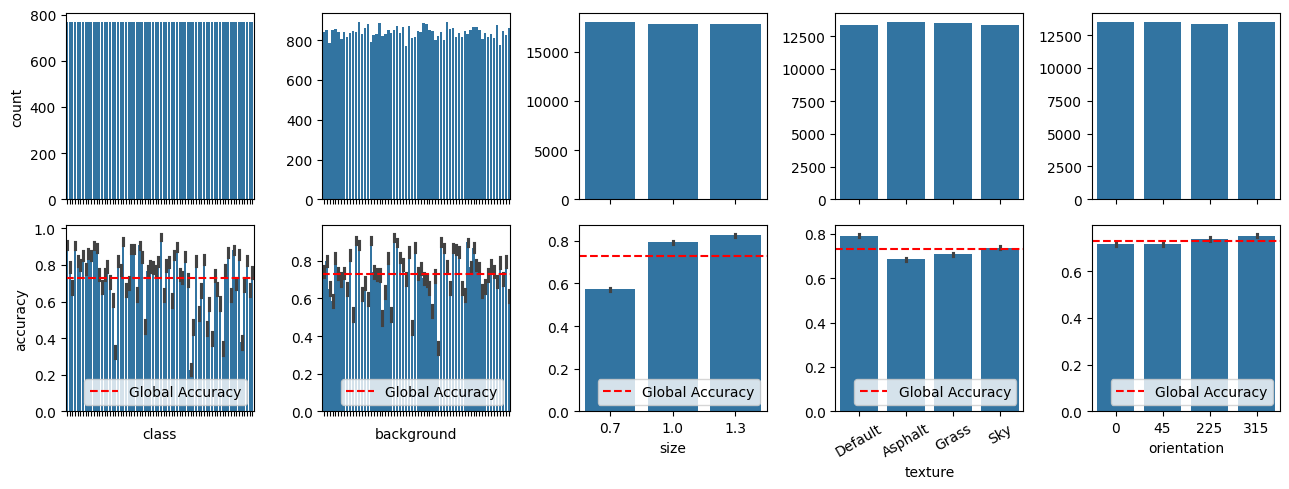

In [3]:
# compute classifier predictions and correctness
for calib_test, dataloader in zip(['calib', 'test'], [calib_loader, test_loader]):

    path_res_file = path_results+f'res_{model_name}_finetuned_lastlayer_{calib_test}.csv'
    if os.path.exists(path_res_file):
        df_res = pd.read_csv(path_res_file)
    else:
        list_res = []
        for data in dataloader:
            images = data[0].cuda()
            labels = dataset.labels_to_idx(data[1])
            labels = torch.tensor(labels).cuda()
            with torch.no_grad():
                logits = classifier(images)
                probas = torch.softmax(logits, axis=1)
            confidences, pred = probas.max(dim=1)
            correct = (pred == labels)
            list_res.append(pd.DataFrame({'confidence': confidences.cpu(), 'prediction': pred.cpu().numpy(), 'correct': correct.cpu().numpy(), 
                'character_name': labels.cpu().numpy(), 'world_name': data[2], 'character_scale': data[3], 'character_texture': data[4], 'camera_yaw': data[5]}))
        df_res = pd.concat(list_res)
        df_res = df_res.reset_index(drop=True)
        df_res.to_csv(path_res_file)
    if calib_test == 'calib':
        df_calib = df_res
    elif calib_test == 'test':
        df_test = df_res


fig, axs = plt.subplots(2, 5, figsize=(13, 5))
for i, attribute in enumerate(attributes_names):
    # count
    sns.countplot(df_test, x=attribute, ax=axs[0, i])
    axs[0, i].set_xlabel('')
    axs[0, i].set_ylabel('')
    axs[0, i].xaxis.set_ticklabels([])
    # accuracy
    sns.barplot(df_test, x=attribute, y='correct', ax=axs[1, i])
    axs[1, i].set_ylabel('')
    if attribute in ['world_name', 'character_name']:
        axs[1, i].xaxis.set_ticklabels([])
    axs[1, i].set_xlabel({'world_name': 'background', 'character_name': 'class', 'character_texture': 'texture', 'camera_yaw': 'orientation', 'character_scale': 'size'}[attribute])
    axs[1, i].axhline(y=df_res['correct'].mean(), color='r', linestyle='--', label='Global Accuracy')
    axs[1, i].legend(loc='lower right')
axs[0, 0].set_ylabel('count')
axs[1, 0].set_ylabel('accuracy')
axs[1, 3].tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.savefig(path_results+'PUG_histo_acc_count.pdf', bbox_inches='tight')

['prediction', 'character_scale', 'character_texture']
840 calib subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.913 AUROC subdomains: 0.787
ECE baseline: 0.085 ECE: 0.011

['prediction']
70 calib subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.913 AUROC subdomains: 0.742
ECE baseline: 0.085 ECE: 0.003

['world_name']
64 calib subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.913 AUROC subdomains: 0.668
ECE baseline: 0.085 ECE: 0.004

['character_scale']
3 calib subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.913 AUROC subdomains: 0.642
ECE baseline: 0.085 ECE: 0.003


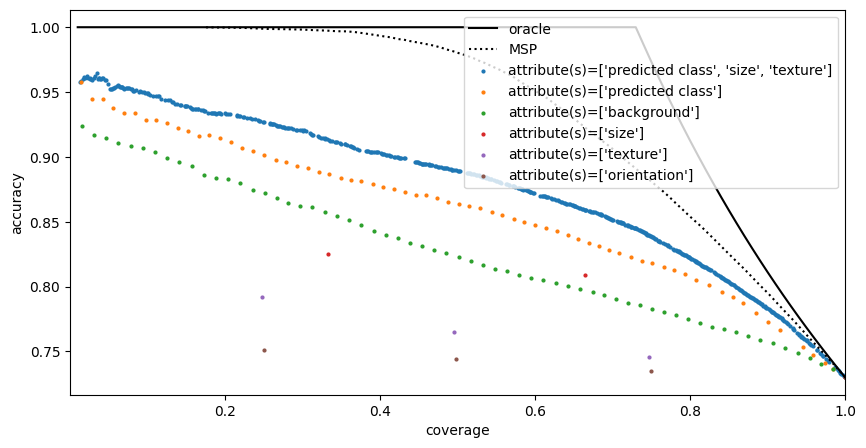

In [12]:
domain_cutoff_baseline = np.linspace(0.01, 1, 100)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = df_test['confidence'] > cut
    coverage_baseline[i] = idx_domain.mean()
    acc_baseline[i] = df_test[idx_domain]['correct'].mean()

domain_cutoff_oracle = np.linspace(0.01, 1, 100)
coverage_oracle = np.zeros_like(domain_cutoff_oracle)
acc_oracle = np.zeros_like(domain_cutoff_oracle)
for i, cut in enumerate(domain_cutoff_oracle):
    idx_domain = df_test.sort_values(by='correct', ascending=False).index[:int(cut*len(df_test))]
    coverage_oracle[i] = cut
    acc_oracle[i] = df_test.loc[idx_domain]['correct'].mean()
    
# plot base
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
# ax1.set_title(f'coverage vs. accuracy')
ax1.set_xlabel('coverage')
ax1.set_ylabel('accuracy')
ax1.plot(coverage_oracle, acc_oracle, c='k', label='oracle')
ax1.plot(coverage_baseline, acc_baseline, c='k', ls=':', label='MSP')

for attributes in [['prediction', 'character_scale', 'character_texture'], ['prediction'], ['world_name'], ['character_scale'], ['character_texture'], ['camera_yaw']]:
    df_test = semantic_binning(df_calib, df_test, attributes, df_res['character_name'].unique())

    coverage = np.zeros(len(df_test['subdomain_score'].unique()))
    accuracy = np.zeros(len(df_test['subdomain_score'].unique()))
    for i, cut in enumerate(sorted(df_test['subdomain_score'].unique(), reverse=True)):
        idx_domain = df_test['subdomain_score'] >= cut
        coverage[i] = idx_domain.mean()
        accuracy[i] = df_test[idx_domain]['correct'].mean()
        attribute_name = [{'world_name': 'background', 'prediction': 'predicted class', 'character_texture': 'texture', 'camera_yaw': 'orientation', 'character_scale': 'size'}[a] for a in attributes]
    ax1.scatter(coverage, accuracy, s=4, label=f'attribute(s)={attribute_name}')
    
plt.legend(loc='upper right')
ax1.set_xlim(0.0001, 1)
plt.savefig(path_results+'acc_cov_PUG.pdf', bbox_inches='tight')

In [5]:
for attributes in [
    ['prediction'], ['world_name'], ['character_scale'], ['character_texture'], ['camera_yaw'],
    ['prediction', 'world_name'],
    ['prediction', 'world_name', 'character_scale'],
    ['prediction', 'world_name', 'character_scale', 'character_texture'],
    ['prediction', 'world_name', 'character_scale', 'character_texture', 'camera_yaw'],
    ['world_name', 'character_scale'],
    ['world_name', 'character_scale', 'character_texture'],
    ['world_name', 'character_scale', 'character_texture', 'camera_yaw'],
    ['prediction', 'character_scale'],
    ['prediction', 'character_scale', 'character_texture'],
    ['prediction', 'character_scale', 'character_texture', 'camera_yaw']]:
    df_test = semantic_binning(df_calib, df_test, attributes, df_res['character_name'].unique())

['prediction']
70 calib subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.913 AUROC subdomains: 0.742
ECE baseline: 0.085 ECE: 0.003

['world_name']
64 calib subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.913 AUROC subdomains: 0.668
ECE baseline: 0.085 ECE: 0.004

['character_scale']
3 calib subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.913 AUROC subdomains: 0.642
ECE baseline: 0.085 ECE: 0.003

['character_texture']
4 calib subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.913 AUROC subdomains: 0.556
ECE baseline: 0.085 ECE: 0.001

['camera_yaw']
4 calib subdomains


In [8]:
attributes = ['prediction', 'character_scale', 'character_texture']
df_test = semantic_binning(df_calib, df_test, attributes, df_res['character_name'].unique())

cuts = np.zeros(len(df_test['subdomain_score'].unique()))
coverage = np.zeros(len(df_test['subdomain_score'].unique()))
accuracy = np.zeros(len(df_test['subdomain_score'].unique()))
for i, cut in enumerate(sorted(df_test['subdomain_score'].unique(), reverse=True)):
    idx_domain = df_test['subdomain_score'] >= cut
    coverage[i] = idx_domain.mean()
    accuracy[i] = df_test[idx_domain]['correct'].mean()
    cuts[i] = cut


['prediction', 'character_scale', 'character_texture']
840 calib subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.913 AUROC subdomains: 0.787
ECE baseline: 0.085 ECE: 0.011



In [40]:
df_test.loc[df_test['subdomain_score'] >= min_cut, attributes].sort_values(by=['prediction', 'character_scale', 'character_texture'])

,prediction,character_scale,character_texture
471,0,1.0,Default
632,0,1.0,Default
2480,0,1.0,Default
2947,0,1.0,Default
3796,0,1.0,Default
...,...,...,...
50292,64,1.3,Sky
50570,64,1.3,Sky
51411,64,1.3,Sky
52082,64,1.3,Sky


In [37]:
df_test

,Unnamed: 0,confidence,prediction,correct,character_name,world_name,character_scale,character_texture,camera_yaw,subdomain_score
0,0,0.414186,42,True,42,TokyoDay,0.7,Default,0,0.857143
1,1,0.999050,6,True,6,ConferenceRoom,1.3,Default,225,0.970588
2,2,0.482039,28,True,28,StylizedEgypt,1.0,Asphalt,45,0.902778
3,3,0.421695,59,False,48,TokyoNight,0.7,Grass,225,0.606557
4,4,0.973155,32,True,32,EuropeanStreet,1.0,Default,225,0.980769
...,...,...,...,...,...,...,...,...,...,...
53755,53755,0.446692,41,True,41,Beach,0.7,Asphalt,45,0.77193
53756,53756,0.993331,6,True,6,ShadyRoad,1.0,Sky,45,0.915254
53757,53757,0.085604,39,False,22,Forge,1.0,Asphalt,45,0.652778
53758,53758,0.139990,58,True,58,ShadyRoad,1.0,Asphalt,315,0.314286


In [41]:
min_cut = min(cuts[accuracy >= 0.95])
subdomains = df_test.loc[df_test['subdomain_score'] >= min_cut, attributes].sort_values(by=['prediction', 'character_scale', 'character_texture']).apply(tuple, 1).unique()
print(len(subdomains), 'subdomains')
print(len(df_test[df_test['subdomain_score'] >= min_cut]), 'datapoints')

scale_to_size = {0.7: 'Small', 1.0: 'Normal', 1.3: 'Big'}
subdomains_renamed = []
for s in subdomains:
    subdomains_renamed.append([dataset.dict_idx_to_label[s[0]], scale_to_size[s[1]], s[2]])
subdomains_renamed  

81 subdomains
4972 datapoints


[['Ammonite', 'Normal', 'Default'],
 ['Ammonite', 'Big', 'Default'],
 ['Ammonite', 'Big', 'Grass'],
 ['Ant', 'Big', 'Default'],
 ['Armadillo', 'Normal', 'Asphalt'],
 ['Armadillo', 'Normal', 'Default'],
 ['Armadillo', 'Normal', 'Grass'],
 ['Armadillo', 'Normal', 'Sky'],
 ['Armadillo', 'Big', 'Default'],
 ['Armadillo', 'Big', 'Sky'],
 ['Bear', 'Normal', 'Default'],
 ['Bear', 'Big', 'Default'],
 ['BlackRockFish', 'Small', 'Default'],
 ['BlackRockFish', 'Normal', 'Default'],
 ['Camel', 'Small', 'Default'],
 ['Camel', 'Small', 'Sky'],
 ['Camel', 'Normal', 'Default'],
 ['Camel', 'Big', 'Default'],
 ['Capybara', 'Small', 'Asphalt'],
 ['Capybara', 'Normal', 'Asphalt'],
 ['Capybara', 'Normal', 'Grass'],
 ['Capybara', 'Big', 'Default'],
 ['Caribou', 'Normal', 'Default'],
 ['Cat', 'Normal', 'Default'],
 ['Cat', 'Big', 'Default'],
 ['Cattle', 'Small', 'Sky'],
 ['Dolphin', 'Big', 'Default'],
 ['EarlessSeal', 'Normal', 'Default'],
 ['Elephant', 'Small', 'Asphalt'],
 ['Elephant', 'Small', 'Default'],

# CLIP zero-shot

In [ ]:
class CLIP_ZeroShot(nn.Module):
    def __init__(self, list_prompts, archi='large'):
        super().__init__()
        if archi == 'large':
            model_name = 'clip-vit-large-patch14'
        elif archi == 'base':
            model_name = 'clip-vit-base-patch16'
        self.CLIP_model = CLIPModel.from_pretrained(path_huggingface+f"openai/{model_name}").cuda()
        self.CLIP_processor = CLIPProcessor.from_pretrained(path_huggingface+f"openai/{model_name}")
        self.list_prompts = list_prompts

    def forward(self, images):
        with torch.no_grad():
            inputs = self.CLIP_processor(text=self.list_prompts, images=images, return_tensors="pt", padding=True)
            for name, tensor in inputs.items():
                inputs[name] = tensor.cuda()
            outputs = self.CLIP_model(**inputs)
        logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
        # probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
        return logits_per_image

In [ ]:
# build model and data
transforms = Compose([ToImage(), Resize(224), CenterCrop(224)])
dataset = UnrealDatasetCustom(csv_path=PUG_ANIMAL_PATH+"labels_pug_animal.csv", images_folder=PUG_ANIMAL_PATH, transform=transforms)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)
prompts = [f'A photo of a {l}.' for l in dataset.dict_label_to_idx.keys()]
clip = CLIP_ZeroShot(prompts, archi='base')

# compute classifier predictions and correctness
path_res_file = path_results+f'res_clip-vit-base-patch16.csv'
if os.path.exists(path_res_file):
    df_res = pd.read_csv(path_res_file)
else:
    list_res = []
    for data in dataloader:
        images = data[0].cuda()
        labels = data[1]
        with torch.no_grad():
            logits = clip(images)
            probas = torch.softmax(logits, axis=1)
        confidences, pred = probas.max(dim=1)
        labels_pred = dataset.idx_to_labels(pred.tolist())
        correct = np.array(labels_pred) == np.array(labels)
        list_res.append(pd.DataFrame({'confidence': confidences.cpu(), 'prediction': labels_pred, 'correct': correct, 
            'character_name': labels, 'world_name': data[2], 'character_scale': data[3], 'character_texture': data[4], 'camera_yaw': data[5]}))
    df_res = pd.concat(list_res)
    df_res = df_res.reset_index(drop=True)
    df_res.to_csv(path_res_file)

avg_confid = df_res['confidence'].mean()
global_acc = df_res['correct'].mean()


# plot some stats
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, attribute in enumerate(attributes_names):
    sns.countplot(df_res, x=attribute, ax=axs.flatten()[i])

fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, attribute in enumerate(attributes_names):
    sns.barplot(df_res, x=attribute, y='confidence', ax=axs.flatten()[i])
    axs.flatten()[i].axhline(y=avg_confid, color='r', linestyle='--', label='Average Confidence')

fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, attribute in enumerate(attributes_names):
    sns.barplot(df_res, x=attribute, y='correct', ax=axs.flatten()[i])
    axs.flatten()[i].axhline(y=global_acc, color='r', linestyle='--', label='Global Accuracy')

In [ ]:
df_train, df_test = train_test_split(df_res, test_size=0.2, random_state=0, shuffle=True, stratify=df_res['character_name'])
df_calib, df_test = train_test_split(df_test, test_size=0.5, random_state=0, shuffle=True, stratify=df_test['character_name'])
len(df_calib)

In [ ]:
auroc_subdomain = {}
for subdomain_attribute in ['world_name', 'character_scale', 'character_texture', 'camera_yaw', 'prediction']:
    df_test = semantic_binning(df_calib, df_test, [subdomain_attribute], df_res['character_name'].unique())
    auroc_subdomain[subdomain_attribute] = roc_auc_score(df_test['correct'], df_test['subdomain_score'])
sorted_attributes = sorted(auroc_subdomain, key=auroc_subdomain.get, reverse=True)

In [ ]:
# domain_cutoff_baseline = np.linspace(0.01, 1, 100)
# coverage_baseline = np.zeros_like(domain_cutoff_baseline)
# acc_baseline = np.zeros_like(domain_cutoff_baseline)
# for i, cut in enumerate(domain_cutoff_baseline):
#     idx_domain = df_test['confidence'] > cut
#     coverage_baseline[i] = idx_domain.mean()
#     acc_baseline[i] = df_test[idx_domain]['correct'].mean()

# domain_cutoff_oracle = np.linspace(0.01, 1, 100)
# coverage_oracle = np.zeros_like(domain_cutoff_oracle)
# acc_oracle = np.zeros_like(domain_cutoff_oracle)
# for i, cut in enumerate(domain_cutoff_oracle):
#     idx_domain = df_test.sort_values(by='correct', ascending=False).index[:int(cut*len(df_test))]
#     coverage_oracle[i] = cut
#     acc_oracle[i] = df_test.loc[idx_domain]['correct'].mean()
    
# # plot base
# fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
# ax1.set_title(f'coverage vs. accuracy')
# ax1.set_xlabel('coverage')
# ax1.set_ylabel('accuracy')
# ax1.plot(coverage_oracle, acc_oracle, c='k', label='oracle')
# ax1.plot(coverage_baseline, acc_baseline, c='k', ls=':', label='filter by confidence')

# for k in range(len(sorted_attributes)):
#     if k > 1: break
#     attributes = sorted_attributes[:k+1]
#     df_test = semantic_binning(df_calib, df_test, attributes)

#     coverage = np.zeros(len(df_test['subdomain_score'].unique()))
#     accuracy = np.zeros(len(df_test['subdomain_score'].unique()))
#     for i, cut in enumerate(sorted(df_test['subdomain_score'].unique(), reverse=True)):
#         idx_domain = df_test['subdomain_score'] >= cut
#         coverage[i] = idx_domain.mean()
#         accuracy[i] = df_test[idx_domain]['correct'].mean()
#     ax1.scatter(coverage, accuracy, s=4, label=f'filter by subdomain - attributes={attributes}')
    
    

# plt.legend()
# ax1.set_xlim(0.0001, 1)

In [ ]:
# baseline: max softmax
domain_cutoff_baseline = np.linspace(df_test['confidence'].min(), df_test['confidence'].max(), 1000)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
risk_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = df_test['confidence'] > cut
    coverage_baseline[i] = idx_domain.mean()
    acc_baseline[i] = df_test.loc[idx_domain, 'correct'].mean()

# plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax1.set_title(f'coverage vs. accuracy')
sc = ax1.scatter(coverage_baseline, acc_baseline, s=4, c=domain_cutoff_baseline, cmap='viridis')
fig.colorbar(sc, ax=ax1, label='max_proba threshold')
ax1.set_xlabel('coverage')
ax1.set_ylabel('accuracy')


for k in range(len(sorted_attributes)):
    if k > 2: break
    attributes = sorted_attributes[:k+1]
    df_test = semantic_binning(df_calib, df_test, attributes, df_res['character_name'].unique(), min_count=5)

    coverage = np.zeros(len(df_test['subdomain_score'].unique()))
    accuracy = np.zeros(len(df_test['subdomain_score'].unique()))
    for i, cut in enumerate(sorted(df_test['subdomain_score'].unique(), reverse=True)):
        idx_domain = df_test['subdomain_score'] >= cut
        coverage[i] = idx_domain.mean()
        accuracy[i] = df_test[idx_domain]['correct'].mean()
    ax1.scatter(coverage, accuracy, s=4, label=f'filter by subdomain - attributes={attributes}')


plt.legend()
# plt.ylim((0.6, 1)) # to filter a point (0,0)

In [ ]:
df_test